In [1]:
# Cloning YOLO github
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt
!pip install utils
!pip install pylabel > /dev/null

Cloning into 'yolov5'...
remote: Enumerating objects: 16670, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 16670 (delta 95), reused 127 (delta 61), pack-reused 16459
Receiving objects: 100% (16670/16670), 15.31 MiB | 32.13 MiB/s, done.
Resolving deltas: 100% (11401/11401), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.3 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.22.0 Requires-Python >=3.8; 1.22.1 Requires-Python >=3.8; 1.22.2 Requires-Python >=3.8; 1.22.3 Requires-Python >=3.8; 1.22.4 Requires-Python >=3.8; 1.23.0 Requires-Python >=3.8; 1.23.0rc1 Requires-Python >=3.8; 1.23.0rc2 Requires-Python >=3.8; 1.23.0rc3 Requires-Python >=3.8; 1.23.1 Requires-Python >=3.8; 1.23.2 Requires-Python >=3.8; 1.23.3 Requires-Python >=3.8; 1.23.4 Requires-Python >=3.8; 1.23.5 Requires-Python >=3.8; 1.24.0 Requires-Python >=3.8; 1.24.0rc1 Requires-Python >=

In [2]:
import torch
import os 
import random
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import logging
import os 
import zipfile
import yaml
import PIL

from IPython.display import Image  # for displaying images
from sklearn.model_selection import train_test_split
from pylabel import importer
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw

logging.getLogger().setLevel(logging.CRITICAL)
random.seed(42)

In [3]:
from pylabel import importer

In [4]:
# Copy images_raw to working directory
# Note: This may take some time depending on the size of your images_raw folder
!cp -r ../input/cosmetic-products-synthetic-images/images_raw ./

In [5]:
# Copy annotations to working directory
!cp -r ../input/cosmetic-products-synthetic-images/coco_instances.json ./

In [6]:
# Copy test image to output directory
!cp -r ../input/cosmetic-products-synthetic-images/test_image.jpg ./

In [7]:
#Specify path to the coco.json file
path_to_annotations = r"./coco_instances.json"
#Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = r"./images_raw"

#Import the dataset into the pylable schema 
dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="BCCD_coco")
dataset.df.head(5)

img_folder  img_filename img_path  img_id  img_width  img_height  \
id                                                                       
0   ./images_raw  00000000.jpg                0        300         300   
1   ./images_raw  00000000.jpg                0        300         300   
2   ./images_raw  00000000.jpg                0        300         300   
3   ./images_raw  00000001.jpg                1        300         300   
4   ./images_raw  00000001.jpg                1        300         300   

   img_depth ann_segmented  ann_bbox_xmin  ann_bbox_ymin  ...  ann_iscrowd  \
id                                                        ...                
0                                   105.5           94.5  ...            0   
1                                    68.5           33.5  ...            0   
2                                    74.5           76.5  ...            0   
3                                    68.5           48.5  ...            0   
4                                    59.5           30.5  ...            0   

    ann_keypoints  ann_pose  ann_truncated  ann_difficult cat_id  \
id                                                                 
0                                                              2   
1                                                              3   
2                                                              1   
3                                                              1   
4                                                              1   

        cat_name cat_supercategory split annotated  
id                                                  
0       Lipstick         cosmetics               1  
1   Makeup Brush         cosmetics               1  
2     Eye Shadow         cosmetics               1  
3     Eye Shadow         cosmetics               1  
4     Eye Shadow         cosmetics               1  

[5 rows x 26 columns]

In [8]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")
print(f"Path to annotations:\n{dataset.path_to_annotations}")


Number of images: 15000
Number of classes: 4
Classes:['Eye Shadow', 'Lipstick', 'Makeup Brush', 'Nail Polish']
Class counts:
Lipstick        7613
Nail Polish     7550
Eye Shadow      7455
Makeup Brush    7372
Name: cat_name, dtype: int64
Path to annotations:
.


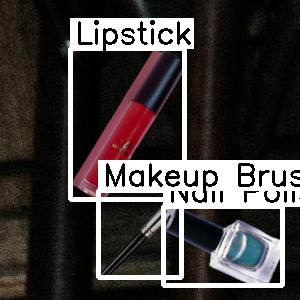

In [9]:
try:
    display(dataset.visualize.ShowBoundingBoxes(2))
    display(dataset.visualize.ShowBoundingBoxes("./images_raw/00000002.jpg"))
except:
    pass

In [10]:
# This cell may take some time depending on the size of the dataset.
dataset.path_to_annotations = "labels"
dataset.export.ExportToYoloV5(output_path='text_files');

Exporting YOLO files...: 100%|██████████| 15000/15000 [01:37<00:00, 154.34it/s]


In [11]:
# Note!!! Only run this code once
path = './text_files' #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")


In [12]:
# Read images and annotations
image_dir = r'./images_raw'
images = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
annotations = [os.path.join('./text_files', x) for x in os.listdir('./text_files') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [13]:
len(train_images),len(train_annotations)

(12000, 12000)

In [14]:
!mkdir images
!mkdir annotations
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [15]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [16]:
!mv annotations labels

In [17]:
shutil.move("./images", "./yolov5")

'./yolov5/images'

In [18]:
shutil.move("./labels", "./yolov5")

'./yolov5/labels'

In [19]:
# Viewing the original unprocessed yaml file

yaml_params = {}
with open(r'dataset.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    yaml_file_list = yaml.load(file, Loader=yaml.FullLoader)
    yaml_params = yaml_file_list
    print(yaml_file_list)

{'names': ['Eye Shadow', 'Lipstick', 'Makeup Brush', 'Nail Polish'], 'nc': 4, 'path': '..', 'train': 'images', 'val': 'images'}


In [20]:
# Adjusting the parameters of the yaml file
yaml_params['path'] = 'images'
yaml_params['train'] = 'train'
yaml_params['val'] = 'val'
yaml_params['test'] = 'test'
yaml_params

{'names': ['Eye Shadow', 'Lipstick', 'Makeup Brush', 'Nail Polish'],
 'nc': 4,
 'path': 'images',
 'train': 'train',
 'val': 'val',
 'test': 'test'}

In [21]:
# Overwriting the new params from the previous ones.
with open(r'dataset.yaml', 'w') as file:
    documents = yaml.dump(yaml_params, file)

In [22]:
# Moving the dataset.yaml inside the yolov5/data folder.
shutil.move("dataset.yaml", "yolov5/data")

'yolov5/data/dataset.yaml'

In [23]:
shutil.move("./test_image.jpg", "./yolov5")

'./yolov5/test_image.jpg'

In [24]:
# Change the current directory inisde the yolov5
%cd ./yolov5

/kaggle/working/yolov5


In [25]:
!python train.py --img 300 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 50 --data dataset.yaml --weights yolov5s.pt --workers 24 --name yolo_cosmetic_det

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.7/616.7 kB 12.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.4/614.4 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.9/606.9 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 20.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolo

In [26]:
!python detect.py --source images/test --weights runs/train/yolo_cosmetic_det/weights/best.pt --conf 0.25 --name yolo_cosmetic_det

detect: weights=['runs/train/yolo_cosmetic_det/weights/best.pt'], source=images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_cosmetic_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
ERROR: Ignored the following versions that require a different python version: 10.0.0 Requires-Python >=3.8; 10.0.1 Requires-Python >=3.8; 10.1.0 Requires-Python >=3.8; 10.2.0 Requires-Python >=3.8; 10.3.0 Requires-Python >=3.8
ERROR: Could not find a version that satisfies the requirement pillow>=10.3.0 (from versions: 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7.0, 1.7.1, 1.7

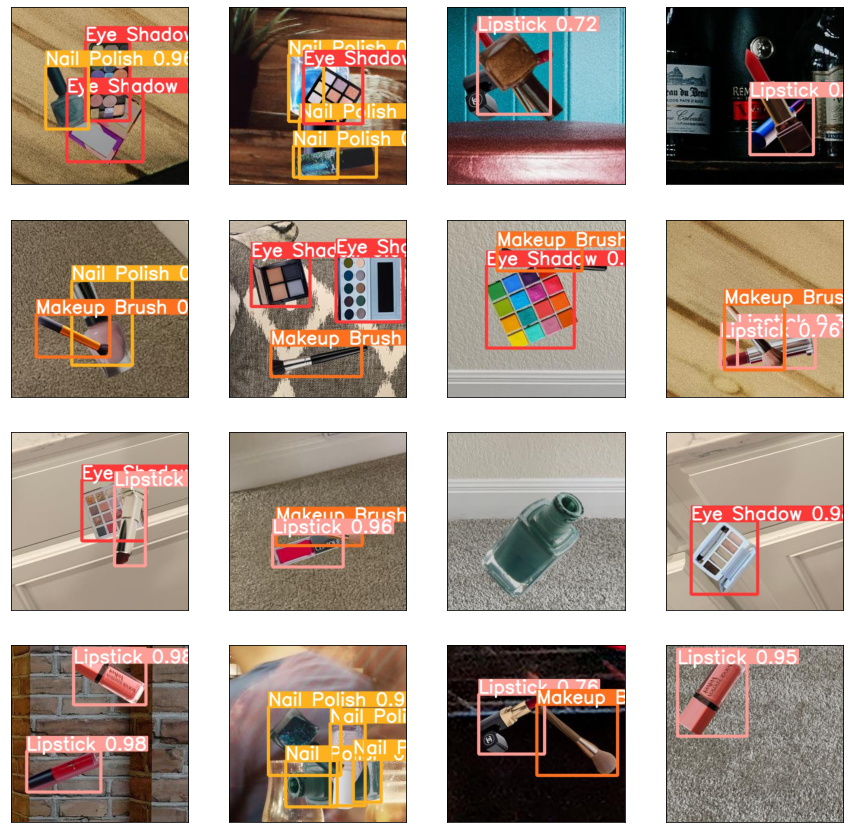

In [27]:
detections_dir = "runs/detect/yolo_cosmetic_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    random_detection_image = PIL.Image.open(random.choice(detection_images))
    ax.imshow(random_detection_image)


In [28]:

!python detect.py --source ./test_image.jpg --weights runs/train/yolo_cosmetic_det/weights/best.pt --conf 0.25 --name yolo_cosmetic_det

detect: weights=['runs/train/yolo_cosmetic_det/weights/best.pt'], source=./test_image.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_cosmetic_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
ERROR: Ignored the following versions that require a different python version: 10.0.0 Requires-Python >=3.8; 10.0.1 Requires-Python >=3.8; 10.1.0 Requires-Python >=3.8; 10.2.0 Requires-Python >=3.8; 10.3.0 Requires-Python >=3.8
ERROR: Could not find a version that satisfies the requirement pillow>=10.3.0 (from versions: 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7.0, 1.7.1

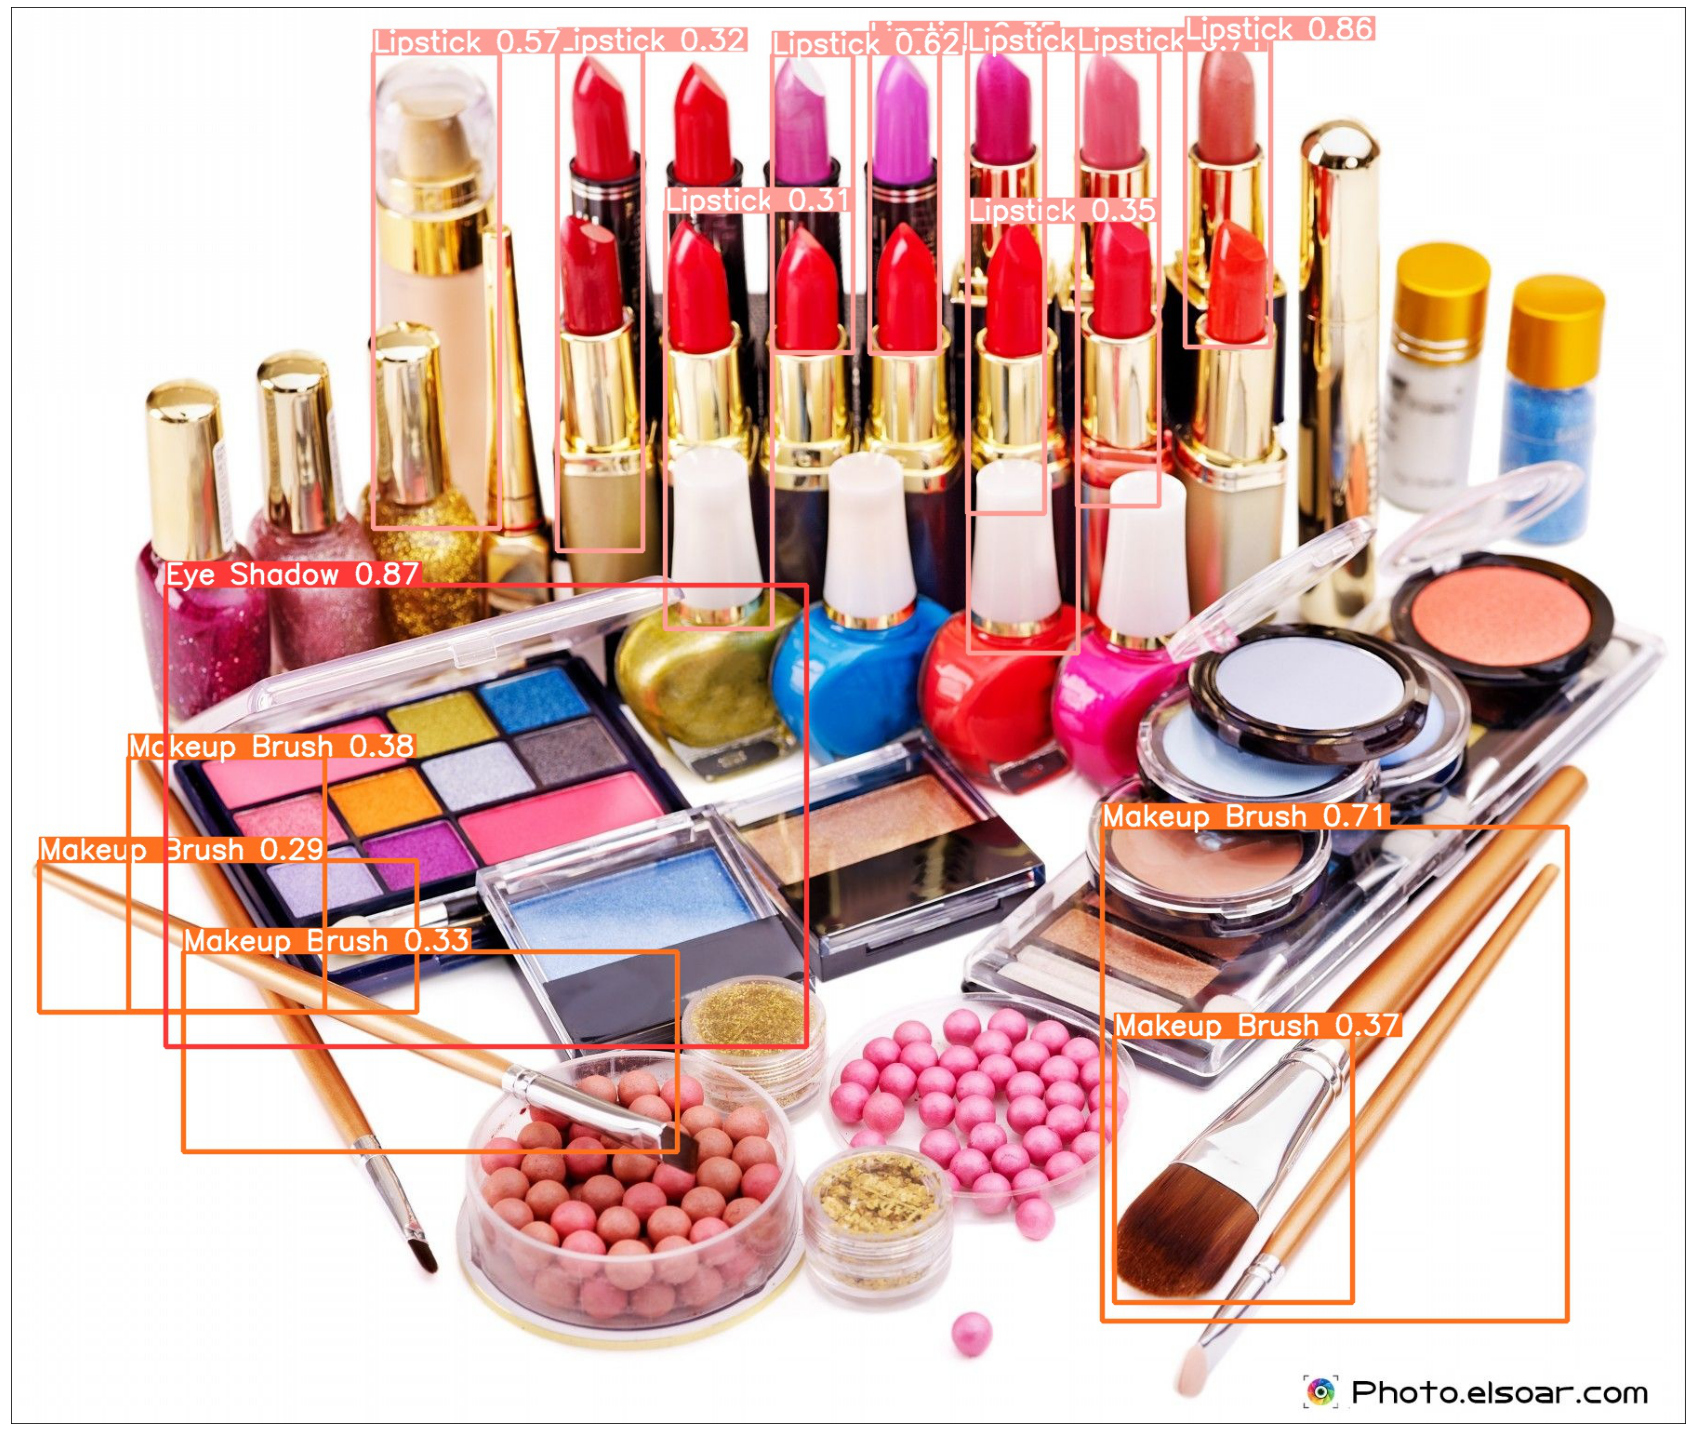

In [29]:
detections_dir = "runs/detect/yolo_cosmetic_det2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]
random_detection_image = PIL.Image.open(random.choice(detection_images))
plt.figure(figsize=(30,30));
plt.imshow(random_detection_image)
plt.xticks([])
plt.yticks([]);